##데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
df = pd.read_json('/content/drive/MyDrive/정비메모분석/data/desc_token_labeled.json')

In [ ]:
print(len(df))
df = df.dropna()
print(len(df))

18743
18743


In [ ]:
df

## 데이터셋 구성

In [ ]:
words = set()
for s in df.desc_token:
    words.update(s.split())

vocab = ['<PAD>', '<unk>', '<BOS>', '<EOS>']
vocab.extend(words)
len(vocab)

2268

In [ ]:
word_to_num = dict()
num_to_word = dict()

for i, label in enumerate(vocab):
    word_to_num[label] = i
    num_to_word[i] = label

len(num_to_word)

2268

In [ ]:
label_to_num = dict()
num_to_label = dict()

labelset = set()
for labels in df.label.unique():
    labelset.update(labels.split(','))

label_vocab = ['<PAD>', '<BOS>', '<EOS>']
label_vocab.extend(labelset)
print(len(label_vocab))

for i, label in enumerate(label_vocab):
    label_to_num[label] = i
    num_to_label[i] = label

len(num_to_label)

239


239

In [ ]:
import pickle

with open('/content/drive/MyDrive/정비메모분석/data/Inference/word_to_num.pkl', 'wb') as f:
    pickle.dump(word_to_num, f)

with open('/content/drive/MyDrive/정비메모분석/data/Inference/num_to_word.pkl', 'wb') as f:
    pickle.dump(num_to_word, f) 

with open('/content/drive/MyDrive/정비메모분석/data/Inference/label_to_num.pkl', 'wb') as f: 
    pickle.dump(label_to_num, f) 

with open('/content/drive/MyDrive/정비메모분석/data/Inference/num_to_label.pkl', 'wb') as f: 
    pickle.dump(num_to_label, f)

In [ ]:
x_data = [[word_to_num[x] for x in s.split()] for s in df.desc_token]

x_data[:10]

[[875, 589, 2054],
 [1750, 1019, 1103],
 [1499, 657],
 [1476, 928, 657],
 [1692],
 [1698, 1174],
 [24, 426, 657],
 [183, 657],
 [928, 657],
 [626, 1823, 657]]

In [ ]:
bos = label_to_num['<BOS>']
eos = label_to_num['<EOS>']

y_data = [[bos] + [label_to_num[x] for x in s.split(',')] + [eos] for s in df.label]
y_data[:10]

[[1, 20, 100, 2],
 [1, 71, 195, 2],
 [1, 92, 2],
 [1, 117, 2],
 [1, 216, 2],
 [1, 221, 2],
 [1, 36, 2],
 [1, 130, 2],
 [1, 117, 2],
 [1, 203, 2]]

In [ ]:
MAX_LABEL_LEN = max([len(y) for y in y_data])
MAX_LABEL_LEN

8

In [ ]:
display(pd.DataFrame(sorted([len(y) for y in y_data])).describe(percentiles=[0.5, 0.8, 0.9, 0.96, 0.99]))

,0
count,18743.000000
mean,3.670810
std,0.840716
min,3.000000
50%,3.000000
80%,4.000000
90%,5.000000
96%,5.000000
99%,6.000000
max,8.000000


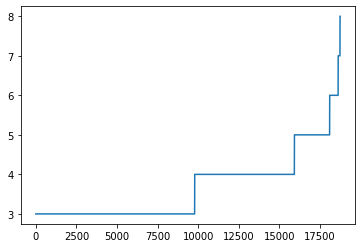

In [ ]:
plt.plot(sorted([len(y) for y in y_data]))

In [ ]:
MAX_LEN = max([len(x) for x in x_data])
MAX_LEN

8

In [ ]:
inputs_data = tf.keras.preprocessing.sequence.pad_sequences(
    x_data, 
    maxlen=MAX_LEN, 
    padding='pre', 
    value=word_to_num['<PAD>'])

print(inputs_data.shape)
inputs_data

(18743, 8)


array([[   0,    0,    0, ...,  875,  589, 2054],
       [   0,    0,    0, ..., 1750, 1019, 1103],
       [   0,    0,    0, ...,    0, 1499,  657],
       ...,
       [   0,    0,    0, ...,    0,  828,  361],
       [   0,    0,    0, ...,    0,    0, 1602],
       [   0,    0,    0, ...,    0,  828,  361]], dtype=int32)

In [ ]:
outputs_data = tf.keras.preprocessing.sequence.pad_sequences(
    y_data, 
    maxlen=MAX_LABEL_LEN, 
    padding='post', 
    value=label_to_num['<PAD>'])

print(outputs_data.shape)
outputs_data

(18743, 8)


array([[  1,  20, 100, ...,   0,   0,   0],
       [  1,  71, 195, ...,   0,   0,   0],
       [  1,  92,   2, ...,   0,   0,   0],
       ...,
       [  1, 187,   2, ...,   0,   0,   0],
       [  1, 187,   2, ...,   0,   0,   0],
       [  1, 187,   2, ...,   0,   0,   0]], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs_data, outputs_data, test_size=0.1, random_state=666)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

16868
16868
1875
1875


In [ ]:
import tensorflow_datasets as tfds

BATCH_SIZE = 64
BUFFER_SIZE = 20000


def create_dataset(inputs, outputs, is_shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': inputs,
            'dec_inputs': outputs[:, :-1]
        },
        {
            'outputs': outputs[:, 1:]
        },
    ))

    dataset = dataset.cache()
    if is_shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = create_dataset(x_train, y_train, is_shuffle=True)
len(train_dataset)

264

In [ ]:
test_dataset = create_dataset(x_test, y_test)
len(test_dataset)

30

## Transformer

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) /
                            tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(
        shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(
        units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(encoder_vocab_size,
                decoder_vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=encoder_vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=decoder_vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=len(label_vocab), name="outputs")(dec_outputs)
    

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
#tf.Tensor([1,2,3],)
a = tf.constant([[1, 2, 0]])
a
create_padding_mask(a)
#(tf.math.equal(x, 0))
tf.cast(tf.equal(a, 0), tf.int32) * eos

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 0, 2]], dtype=int32)>

## 모델 구성

In [ ]:
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

In [ ]:
tf.keras.backend.clear_session()

model = transformer(
    encoder_vocab_size=len(vocab),
    decoder_vocab_size=len(label_vocab),
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    1634816     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LABEL_LEN - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = np.array(d_model)
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        config = {
        'd_model': self.d_model.numpy(),
        'warmup_steps': self.warmup_steps,

        }
        return config

Text(0.5, 0, 'Train Step')

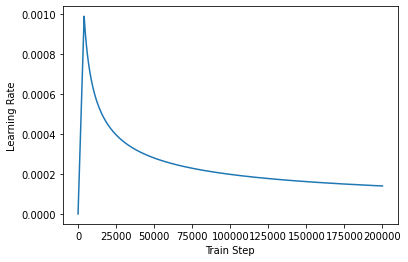

In [ ]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
a = tf.constant([1,2,3,4,5])
tf.math.less(a, 3)

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([ True,  True, False, False, False])>

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

last_token_num = label_to_num['<EOS>'] # 제거할 토큰의 끝번호가 EOS라고 가정

def accuracy(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, shape=(-1, MAX_LABEL_LEN -1)), tf.int32)
    pad_mask = tf.cast(tf.math.less_equal(y_true, last_token_num), tf.int32)

    y_pred = tf.math.argmax(y_pred, axis=-1, output_type=tf.int32)
    y_pred = tf.math.add(y_pred, pad_mask)
    
    match = tf.math.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), tf.int32))
    total = tf.math.reduce_sum(tf.cast(tf.math.greater(y_true, last_token_num), tf.int32))

    return tf.math.divide(match, total)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

##테스트

In [ ]:
EPOCHS = 8
# model_checkpoint_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',verbose =1,
#     mode='min', restore_best_weights=True
# )
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS, verbose=1)#, callbacks=[model_checkpoint_callback])

Epoch 1/8
264/264 [==============================] - 12s 26ms/step - loss: 1.4240 - accuracy: 0.0773 - val_loss: 0.8488 - val_accuracy: 0.3626
Epoch 2/8
264/264 [==============================] - 6s 22ms/step - loss: 0.6702 - accuracy: 0.4807 - val_loss: 0.3912 - val_accuracy: 0.6749
Epoch 3/8
264/264 [==============================] - 6s 21ms/step - loss: 0.3501 - accuracy: 0.7107 - val_loss: 0.2114 - val_accuracy: 0.8176
Epoch 4/8
264/264 [==============================] - 6s 21ms/step - loss: 0.2052 - accuracy: 0.8254 - val_loss: 0.1604 - val_accuracy: 0.8789
Epoch 5/8
264/264 [==============================] - 6s 21ms/step - loss: 0.1380 - accuracy: 0.8808 - val_loss: 0.1333 - val_accuracy: 0.9070
Epoch 6/8
264/264 [==============================] - 6s 21ms/step - loss: 0.1060 - accuracy: 0.9070 - val_loss: 0.1145 - val_accuracy: 0.9136
Epoch 7/8
264/264 [==============================] - 6s 21ms/step - loss: 0.0913 - accuracy: 0.9191 - val_loss: 0.1130 - val_accuracy: 0.9196
Epoch

In [ ]:
model.save_weights('/content/drive/MyDrive/정비메모분석/modules/models/weights')
#model.save('/content/drive/MyDrive/정비메모분석/modules')

In [ ]:
y_test[:,1:]

array([[ 44,  67,   2, ...,   0,   0,   0],
       [136,   2,   0, ...,   0,   0,   0],
       [ 18, 237,   2, ...,   0,   0,   0],
       ...,
       [ 36,   2,   0, ...,   0,   0,   0],
       [150, 237,   2, ...,   0,   0,   0],
       [147,   2,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
y_pred

array([[ 44,  67,   2, ...,   2,   2,   2],
       [136,   2,   2, ...,   2,   2,   2],
       [ 18, 237,   2, ...,   2,   2,   2],
       ...,
       [ 36,   2,   2, ...,   2,   2,   2],
       [150, 237,   2, ...,   2,   2,   2],
       [147,   2,   2, ...,   2,   2,   2]])

In [ ]:
def draw_history(history):
    fig = plt.figure(figsize=(15, 5))
    loss_ax = fig.add_subplot(1, 2, 1)
    acc_ax = fig.add_subplot(1, 2, 2)

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='test loss')
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'r', label='test acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_xlabel('epoch')
    acc_ax.set_ylabel('accuray')

    plt.show()

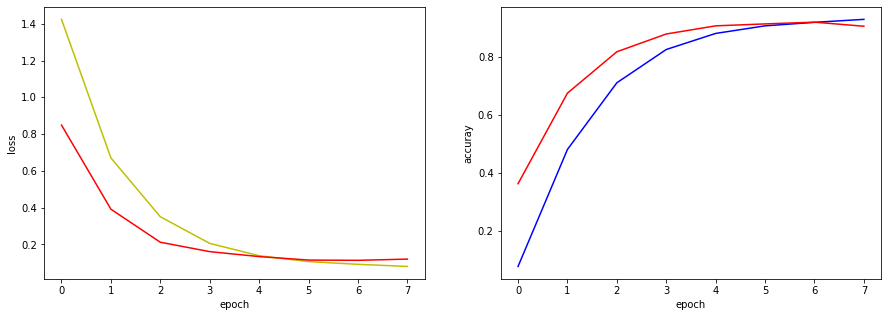

In [ ]:
draw_history(history)

In [ ]:
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})

In [ ]:
def predict(sentence):
    eos = label_to_num['<EOS>']
    #sentence = preprocess_sentence(sentence)
    sentence = [word_to_num[w] for w in sentence.split()]
    #sentence = tf.keras.preprocessing.sequence.pad_sequences([sentence], maxlen=max_len, padding='post')
    sentence = tf.expand_dims(sentence, axis=0)

    output_sequence = tf.expand_dims([word_to_num['<BOS>']], 0)
    result = []

    for _ in range(MAX_LABEL_LEN):
        pred = model.predict([sentence, output_sequence])
        pred_num = np.argmax((tf.nn.softmax(pred[:,-1,:])))
        if pred_num == eos:
            break

        output_sequence = tf.concat([output_sequence, tf.constant([[pred_num]])], axis=-1)
        result.append(pred_num)

    return result

In [ ]:
pred = predict('블랙박스 메모리카드 교환 정상작동 확인가능')

In [ ]:
pred

[124, 56, 83]

In [ ]:
[num_to_label[x] for x in pred]

['블랙박스', '메모리카드', '확인 가능']